<a href="https://colab.research.google.com/github/AbdulHakkam/SDGP/blob/ML-Model/Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2 as cv
import pandas as pd
import sklearn.metrics as metrics
from tensorflow import keras

import numpy as np

!pip install livelossplot
from livelossplot import PlotLossesKeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator


(ds_train,ds_test),info = tfds.load('StanfordDogs', split=["train","test"], with_info=True,as_supervised=True)  #retreiving dataset
print(info)






tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [5]:
def preprocess(image,label):                                                   #preprocess dataset before training by converting type and resizing it to 224,224,3

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (244,244), method='nearest')
  
    label = tf.one_hot(label,120)

    return image, label
def prepare(dataset, batch_size=None):                                         #prepares the dataset for training by preprocessing,shuffling and then prefetching the data                       
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


  



ds_train = prepare(ds_train,batch_size=32)
ds_test =prepare(ds_test,batch_size=32)



IMG_SHAPE=(244,244,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(120, activation='softmax')
])


In [6]:
def augment_using_ops(images, labels):
	
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	
	return (images, labels)
 
 




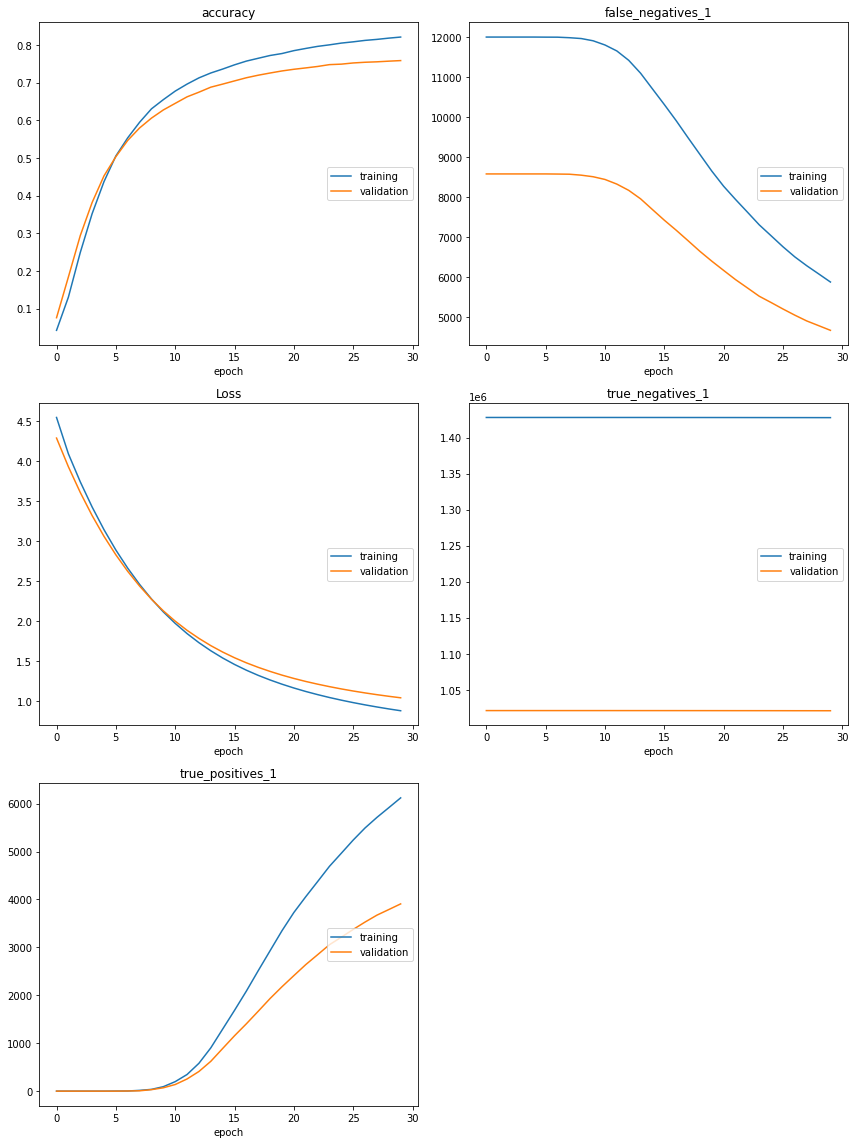

accuracy
	training         	 (min:    0.042, max:    0.821, cur:    0.821)
	validation       	 (min:    0.076, max:    0.759, cur:    0.759)
false_negatives_1
	training         	 (min: 5879.000, max: 12000.000, cur: 5879.000)
	validation       	 (min: 4672.000, max: 8580.000, cur: 4672.000)
Loss
	training         	 (min:    0.882, max:    4.548, cur:    0.882)
	validation       	 (min:    1.044, max:    4.290, cur:    1.044)
true_negatives_1
	training         	 (min: 1427763.000, max: 1428000.000, cur: 1427763.000)
	validation       	 (min: 1020811.000, max: 1021020.000, cur: 1020811.000)
true_positives_1
	training         	 (min:    0.000, max: 6121.000, cur: 6121.000)
	validation       	 (min:    0.000, max: 3908.000, cur: 3908.000)
375/375 [==============================] - 98s 251ms/step - loss: 0.8819 - accuracy: 0.8210 - true_negatives_1: 1427763.0000 - false_negatives_1: 5879.0000 - true_positives_1: 6121.0000 - val_loss: 1.0436 - val_accuracy: 0.7585 - val_true_negatives_1: 102

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TruePositives()]
              )

history = model.fit(ds_train,epochs=30,validation_data=ds_test,callbacks=[PlotLossesKeras()])